In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
import optuna

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import (
    mean_absolute_error,
    classification_report
)
from features_all import *
from dotenv import load_dotenv

load_dotenv()

True

In [29]:
df = pd.read_parquet('data/train.parquet')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309648 entries, 0 to 309647
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nm_id           309648 non-null  object        
 1   dt              309648 non-null  datetime64[ns]
 2   qty             309648 non-null  int64         
 3   price           309648 non-null  int64         
 4   is_promo        309648 non-null  int64         
 5   prev_leftovers  309648 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 14.2+ MB


Файлы `train.parquet` и `test.parquet` содержат:

- **nm_id** — анонимный идентификатор товара  
- **dt** — дата  
- **price** — цена товара в этот день  
- **is_promo** — флаг участия товара в промо-акции  
- **prev_leftovers** — остаток товара на складе на начало дня  
- **qty** — количество проданных единиц, присутствует только в `train` (целевой признак)

**Начало периода:** 2024-07-04  
**Конец периода:** 2025-07-07

Статистика по продажам:
    Среднее: 0.8459056735389862
    Медиана: 0.0
    Мода: 0
    Дисперсия: 23.895656969245444
    Стандартное отклонение: 4.888318419379556
    


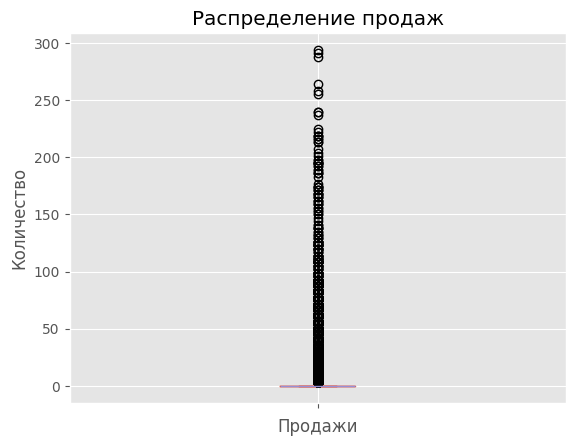

In [31]:
qty = df['qty']

print(
    f"""Статистика по продажам:
    Среднее: {qty.mean()}
    Медиана: {qty.median()}
    Мода: {qty.mode()[0]}
    Дисперсия: {qty.var(ddof=0)}
    Стандартное отклонение: {qty.std(ddof=0)}
    """
)

df[['qty']].plot.box()
plt.title('Распределение продаж')
plt.xlabel('Продажи')
plt.ylabel('Количество')
plt.xticks([1], ['']) 
plt.style.use('ggplot')      
plt.show()

In [32]:
df.head()

,nm_id,dt,qty,price,is_promo,prev_leftovers
0,015ecac1-0d4d-4272-9f9c-7c62a742a679,2024-07-04,0,2940,0,54
1,02790618-93a6-4a2e-92e2-72cbb0bf24cf,2024-07-04,3,6543,0,75
2,03cf7d0c-4709-409d-a964-44558ada7e3d,2024-07-04,3,4983,0,66
3,0407f293-33e5-4c34-8236-9ddef5a166f0,2024-07-04,3,1971,1,132
4,046336e9-58cd-4d0f-b521-c70607fd9ec4,2024-07-04,0,2133,1,87


In [33]:
# 1. Фичи, которые НЕ зависят от qty — считаем на всём df
df = add_temporal_features(df)
df = add_price_features(df)
df = add_promo_features(df)
df = add_leftovers_features(df)
df = add_interaction_features(df)

# 2. Сплит
threshold_time = df["dt"].quantile(0.9)
train_mask = df["dt"] <= threshold_time

# 3. Фичи, зависящие от qty — считаем только на train
train_df = df[train_mask].copy()
train_df = add_sales_lag_features(train_df)
train_df = add_item_features(train_df)          
train_df = add_elasticity_features(train_df)

test_df = df[~train_mask].copy()

# item_features без qty (lifetime, mean_price, price_std — посчитаются)
test_df = add_item_features(test_df)

# Лаги для теста: берём хвост train и голову test, считаем, оставляем только test
border_df = pd.concat([
    df[train_mask].tail(28 * df["nm_id"].nunique()),  # последние 28 дней train
    test_df
]).sort_values(["nm_id", "dt"])
border_df = add_sales_lag_features(border_df)

# Забираем только test-строки обратно
test_df = border_df[border_df["dt"] > threshold_time].copy()

# 5. Собираем X, y
drop_cols = ["qty"]
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["qty"]
X_test = test_df.drop(columns=drop_cols, errors="ignore")
y_test = df.loc[~train_mask, "qty"]

/Users/vladpalamarchuk/Documents/coding/hse-hackathon/features_all.py:231: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: rolling_corr(g, window))


In [ ]:
# Приводим колонки к общему виду
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

In [38]:
# Веса для MAE 
weights_train = np.where(y_train > 0, 7.0, 1.0)
weights_test = np.where(y_test > 0, 7.0, 1.0)

In [39]:
train_pool = Pool(X_train, y_train, weight=weights_train, cat_features=["is_promo", "nm_id"])
eval_pool = Pool(X_test, y_test, weight=weights_test, cat_features=["is_promo", "nm_id"])

with mlflow.start_run():
    model = CatBoostRegressor(
        iterations=300,
        learning_rate=0.03,
        random_seed=42,
        loss_function="MAE"
    )

    model.fit(
        train_pool,
        eval_set=eval_pool,
        plot=True,
        early_stopping_rounds=50,
        use_best_model=True,
        verbose=30
    )

    mlflow.log_params(model.get_params())
    mlflow.log_param("feature_names", list(X_train.columns))
    mlflow.log_param("cat_features", ["is_promo", "nm_id"])
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    })
    mlflow.log_dict(feature_importance.to_dict(), "feature_importance.json")

    mlflow.log_metric("val_mae", model.best_score_["validation"]["MAE"])
    mlflow.catboost.log_model(model, artifact_path="model")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3.1580240	test: 4.1470123	best: 4.1470123 (0)	total: 73.4ms	remaining: 21.9s
30:	learn: 2.7677140	test: 3.3838343	best: 3.3838343 (30)	total: 1.61s	remaining: 14s
60:	learn: 2.5488156	test: 2.9442775	best: 2.9442775 (60)	total: 2.99s	remaining: 11.7s
90:	learn: 2.4325739	test: 2.7492170	best: 2.7492170 (90)	total: 4.19s	remaining: 9.63s
120:	learn: 2.3698086	test: 2.6720957	best: 2.6720957 (120)	total: 5.31s	remaining: 7.86s
150:	learn: 2.3289673	test: 2.6311521	best: 2.6311521 (150)	total: 6.34s	remaining: 6.25s
180:	learn: 2.2854519	test: 2.5978237	best: 2.5978237 (180)	total: 7.3s	remaining: 4.8s
210:	learn: 2.2543993	test: 2.5754430	best: 2.5754430 (210)	total: 8.25s	remaining: 3.48s
240:	learn: 2.2355868	test: 2.5744689	best: 2.5741116 (234)	total: 9.19s	remaining: 2.25s
270:	learn: 2.2249975	test: 2.5725346	best: 2.5719063 (252)	total: 10.1s	remaining: 1.08s
299:	learn: 2.2091920	test: 2.5715667	best: 2.5695952 (281)	total: 11s	remaining: 0us

bestTest = 2.569595244
bes

2026/02/16 23:31:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run thoughtful-stoat-557 at: http://localhost:5050/#/experiments/1/runs/61bb5101fda548948fb60fbc22393248
🧪 View experiment at: http://localhost:5050/#/experiments/1


In [ ]:

train_pool = Pool(X_train, y_train, weight=weights_train, cat_features=["is_promo", "nm_id"])
eval_pool = Pool(X_test, y_test, weight=weights_test, cat_features=["is_promo", "nm_id"])


# ── 1. Optuna: подбор гиперпараметров ──

def objective(trial):
    params = {
        "iterations": 3000,
        "learning_rate": trial.suggest_float("lr", 0.005, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 2.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "loss_function": "MAE",
        "random_seed": 42,
        "verbose": 0,
    }

    # Каждый trial — вложенный run в MLflow
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
        model = CatBoostRegressor(**params)
        model.fit(
            train_pool,
            eval_set=eval_pool,
            early_stopping_rounds=50,
            use_best_model=True,
        )

        mae = model.best_score_["validation"]["MAE"]

        mlflow.log_params(trial.params)
        mlflow.log_metric("val_mae", mae)
        mlflow.log_metric("best_iteration", model.best_iteration_)

    return mae


# ── 2. Запуск: родительский run оборачивает все trials ──

with mlflow.start_run(run_name="optuna_search"):

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Логируем лучшие параметры
    mlflow.log_params({f"best_{k}": v for k, v in study.best_params.items()})
    mlflow.log_metric("best_val_mae", study.best_value)

    # ── 3. Финальная модель с лучшими параметрами ──

    best = study.best_params
    final_model = CatBoostRegressor(
        iterations=3000,
        learning_rate=best["lr"],
        depth=best["depth"],
        l2_leaf_reg=best["l2_leaf_reg"],
        min_data_in_leaf=best["min_data_in_leaf"],
        bagging_temperature=best["bagging_temperature"],
        random_strength=best["random_strength"],
        loss_function="MAE",
        random_seed=42,
        verbose=50,
    )
    final_model.fit(
        train_pool,
        eval_set=eval_pool,
        early_stopping_rounds=100,
        use_best_model=True,
    )

    final_mae = final_model.best_score_["validation"]["MAE"]
    mlflow.log_metric("final_val_mae", final_mae)
    mlflow.log_param("final_best_iteration", final_model.best_iteration_)
    mlflow.log_param("feature_names", list(X_train.columns))
    mlflow.log_param("cat_features", ["is_promo", "nm_id"])

    feature_importance = pd.DataFrame({
        "feature": X_train.columns,
        "importance": final_model.feature_importances_,
    }).sort_values("importance", ascending=False)
    mlflow.log_dict(feature_importance.to_dict(), "feature_importance.json")

    mlflow.catboost.log_model(final_model, name="model")

[I 2026-02-16 23:35:21,985] A new study created in memory with name: no-name-6605f88f-b463-4e24-a86b-ecfdf4e7e0c5
[I 2026-02-16 23:35:35,280] Trial 0 finished with value: 2.5618856989755776 and parameters: {'lr': 0.04007406112262744, 'depth': 6, 'l2_leaf_reg': 1.3131719902736332, 'min_data_in_leaf': 37, 'bagging_temperature': 0.8725047945006055, 'random_strength': 0.5042550300109623}. Best is trial 0 with value: 2.5618856989755776.


🏃 View run trial_0 at: http://localhost:5050/#/experiments/1/runs/430f7b10f9684cf39d922856650b0bb2
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:35:58,092] Trial 1 finished with value: 2.498328871706941 and parameters: {'lr': 0.05275173145315531, 'depth': 8, 'l2_leaf_reg': 5.42122102231091, 'min_data_in_leaf': 38, 'bagging_temperature': 0.8304319517762828, 'random_strength': 1.1119737699236294}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_1 at: http://localhost:5050/#/experiments/1/runs/ed22dbaf4f4a42239ddbf6293256c3bc
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:36:08,198] Trial 2 finished with value: 2.6011519386507067 and parameters: {'lr': 0.06095421222811544, 'depth': 10, 'l2_leaf_reg': 9.334033452549619, 'min_data_in_leaf': 9, 'bagging_temperature': 1.395778637273429, 'random_strength': 0.7186612098512073}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_2 at: http://localhost:5050/#/experiments/1/runs/283a622be3e04575807251c053e069bb
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:36:21,987] Trial 3 finished with value: 2.5841458097256753 and parameters: {'lr': 0.021152759524164053, 'depth': 9, 'l2_leaf_reg': 4.751520015760317, 'min_data_in_leaf': 8, 'bagging_temperature': 1.0815430956774286, 'random_strength': 1.729676135865455}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_3 at: http://localhost:5050/#/experiments/1/runs/d50cb1d41e7c40beb84e1e7365ec37b8
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:37:04,876] Trial 4 finished with value: 2.578312988265959 and parameters: {'lr': 0.008473234443436237, 'depth': 4, 'l2_leaf_reg': 7.547445814549219, 'min_data_in_leaf': 35, 'bagging_temperature': 0.008357043189213709, 'random_strength': 1.4635265903451253}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_4 at: http://localhost:5050/#/experiments/1/runs/784bd727deec41079f4d0f85fac91c16
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:37:12,208] Trial 5 finished with value: 2.5935330017154756 and parameters: {'lr': 0.08713320788176675, 'depth': 8, 'l2_leaf_reg': 4.672198686023232, 'min_data_in_leaf': 7, 'bagging_temperature': 0.08995781672399117, 'random_strength': 0.6797975186623899}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_5 at: http://localhost:5050/#/experiments/1/runs/cc97e0adfdb44704b1f14ef4eac4dc8c
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:37:41,064] Trial 6 finished with value: 2.7100778138149453 and parameters: {'lr': 0.013855037532122314, 'depth': 9, 'l2_leaf_reg': 4.657189282936157, 'min_data_in_leaf': 5, 'bagging_temperature': 1.4082010051511193, 'random_strength': 0.038285808686265854}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_6 at: http://localhost:5050/#/experiments/1/runs/e8fd0b511f6f44bfa2522f16b4ecd746
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:37:50,586] Trial 7 finished with value: 2.5665736336562075 and parameters: {'lr': 0.052693940531673394, 'depth': 7, 'l2_leaf_reg': 6.752545669146423, 'min_data_in_leaf': 44, 'bagging_temperature': 0.8284672782720364, 'random_strength': 1.6005096577458988}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_7 at: http://localhost:5050/#/experiments/1/runs/6c1bf66b72384c2ea95438b02383f865
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:38:32,353] Trial 8 finished with value: 2.767895484993437 and parameters: {'lr': 0.00637685571916688, 'depth': 8, 'l2_leaf_reg': 4.082335741682864, 'min_data_in_leaf': 40, 'bagging_temperature': 0.9961572506446168, 'random_strength': 0.017378064196683418}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_8 at: http://localhost:5050/#/experiments/1/runs/73401b3103224230adcb046f9245fb6b
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:38:56,450] Trial 9 finished with value: 2.525313210307339 and parameters: {'lr': 0.024504611575901895, 'depth': 9, 'l2_leaf_reg': 1.7843723843280368, 'min_data_in_leaf': 9, 'bagging_temperature': 1.496596709007104, 'random_strength': 0.65560264097221}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_9 at: http://localhost:5050/#/experiments/1/runs/31f20aa9e607449380bfdd21757e9198
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:39:11,064] Trial 10 finished with value: 2.583521968611718 and parameters: {'lr': 0.031748420385669114, 'depth': 5, 'l2_leaf_reg': 2.8612693534325557, 'min_data_in_leaf': 24, 'bagging_temperature': 1.9411526751353578, 'random_strength': 1.1880504159144465}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_10 at: http://localhost:5050/#/experiments/1/runs/e1606434d7c8421698f41ffe52cc971d
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:39:30,643] Trial 11 finished with value: 2.5799609553139318 and parameters: {'lr': 0.02033177541516295, 'depth': 10, 'l2_leaf_reg': 1.248273875882271, 'min_data_in_leaf': 22, 'bagging_temperature': 0.5518823125081246, 'random_strength': 1.0879313390911058}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_11 at: http://localhost:5050/#/experiments/1/runs/65f61106f63f416c93286e75571de07c
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:39:56,469] Trial 12 finished with value: 2.5682438780845356 and parameters: {'lr': 0.030833102739417657, 'depth': 7, 'l2_leaf_reg': 2.6636409302868893, 'min_data_in_leaf': 17, 'bagging_temperature': 1.5465419257285775, 'random_strength': 0.4497598068806091}. Best is trial 1 with value: 2.498328871706941.


🏃 View run trial_12 at: http://localhost:5050/#/experiments/1/runs/06c6979d68694813a7c26f964911ce60
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:41:12,973] Trial 13 finished with value: 2.4664555523146956 and parameters: {'lr': 0.014762575560341157, 'depth': 8, 'l2_leaf_reg': 6.34280329618129, 'min_data_in_leaf': 31, 'bagging_temperature': 1.876015858867992, 'random_strength': 1.9625405284967212}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_13 at: http://localhost:5050/#/experiments/1/runs/261fb99233c343ecbceac62111e7854c
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:41:53,523] Trial 14 finished with value: 2.5752668874543567 and parameters: {'lr': 0.013785992309144407, 'depth': 8, 'l2_leaf_reg': 6.544320292237454, 'min_data_in_leaf': 50, 'bagging_temperature': 0.4975257259423823, 'random_strength': 1.353783399185642}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_14 at: http://localhost:5050/#/experiments/1/runs/f883930ce0da45aabe90e5dc5747b079
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:42:26,044] Trial 15 finished with value: 2.599606667337831 and parameters: {'lr': 0.011441610487774187, 'depth': 6, 'l2_leaf_reg': 8.606127706879937, 'min_data_in_leaf': 29, 'bagging_temperature': 1.9880769599148969, 'random_strength': 1.9542704616887168}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_15 at: http://localhost:5050/#/experiments/1/runs/4242efb8fd8b408ea5993671819a8b69
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:42:40,709] Trial 16 finished with value: 2.539112983892129 and parameters: {'lr': 0.0993647499778761, 'depth': 6, 'l2_leaf_reg': 6.0802030993257885, 'min_data_in_leaf': 30, 'bagging_temperature': 0.5445613422418445, 'random_strength': 1.9743093014470512}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_16 at: http://localhost:5050/#/experiments/1/runs/d9fdb54e28f64b8bbe4942dd7c457e8f
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:42:48,966] Trial 17 finished with value: 2.527609686780016 and parameters: {'lr': 0.061522475669352275, 'depth': 8, 'l2_leaf_reg': 7.973580992641113, 'min_data_in_leaf': 45, 'bagging_temperature': 1.7517443323194755, 'random_strength': 1.7372792117371176}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_17 at: http://localhost:5050/#/experiments/1/runs/1b3978f7b6b74c1db79d78073065650d
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:43:35,418] Trial 18 finished with value: 2.604847411620058 and parameters: {'lr': 0.005976645241989559, 'depth': 7, 'l2_leaf_reg': 6.031077419818294, 'min_data_in_leaf': 34, 'bagging_temperature': 1.1929670843114213, 'random_strength': 0.9484968162383061}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_18 at: http://localhost:5050/#/experiments/1/runs/d0e64c571f214a6fab68e4b71de237fd
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:43:57,014] Trial 19 finished with value: 2.5823900949721996 and parameters: {'lr': 0.01760584705554356, 'depth': 9, 'l2_leaf_reg': 9.943455387202219, 'min_data_in_leaf': 18, 'bagging_temperature': 0.30376753971347015, 'random_strength': 1.2538622072880254}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_19 at: http://localhost:5050/#/experiments/1/runs/72c953883e524f38a4dd962e288ab148
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:44:26,144] Trial 20 finished with value: 2.6375947546243115 and parameters: {'lr': 0.00948948199513415, 'depth': 5, 'l2_leaf_reg': 3.736497360665391, 'min_data_in_leaf': 32, 'bagging_temperature': 0.7409048030159899, 'random_strength': 0.3179527417816468}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_20 at: http://localhost:5050/#/experiments/1/runs/1a13e67ffddd4283879d3a4d92142862
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:45:02,245] Trial 21 finished with value: 2.495490851836772 and parameters: {'lr': 0.03699352193744972, 'depth': 9, 'l2_leaf_reg': 2.302212814072879, 'min_data_in_leaf': 26, 'bagging_temperature': 1.593017006513905, 'random_strength': 0.9074550190355986}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_21 at: http://localhost:5050/#/experiments/1/runs/629459b28ac64cec8ba63babd197e12e
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:45:21,894] Trial 22 finished with value: 2.5767050174523454 and parameters: {'lr': 0.035596668494568176, 'depth': 10, 'l2_leaf_reg': 5.502464965322816, 'min_data_in_leaf': 25, 'bagging_temperature': 1.7718019389821402, 'random_strength': 0.9122790099883653}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_22 at: http://localhost:5050/#/experiments/1/runs/cd07c4308142406bb485f251464d0f60
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:45:32,769] Trial 23 finished with value: 2.560722701449813 and parameters: {'lr': 0.051473578274959436, 'depth': 8, 'l2_leaf_reg': 2.789626249616868, 'min_data_in_leaf': 39, 'bagging_temperature': 1.7434988562066744, 'random_strength': 0.8822578826387766}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_23 at: http://localhost:5050/#/experiments/1/runs/4f75619f366d417c9d3390226772cac4
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:45:41,147] Trial 24 finished with value: 2.6163823556744785 and parameters: {'lr': 0.042816517860891315, 'depth': 9, 'l2_leaf_reg': 7.366570093119368, 'min_data_in_leaf': 19, 'bagging_temperature': 1.1463236639565328, 'random_strength': 1.4839561379379078}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_24 at: http://localhost:5050/#/experiments/1/runs/da7a60796db642d9b7ac1209b63c5f5d
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:45:54,024] Trial 25 finished with value: 2.593954670849872 and parameters: {'lr': 0.03070836837522764, 'depth': 8, 'l2_leaf_reg': 5.570005474119949, 'min_data_in_leaf': 27, 'bagging_temperature': 1.6102806478425942, 'random_strength': 1.1162113107020728}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_25 at: http://localhost:5050/#/experiments/1/runs/661696ed5f304ccaa0e2ffa3f09d903b
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:46:17,076] Trial 26 finished with value: 2.474877491184763 and parameters: {'lr': 0.0715090198541279, 'depth': 7, 'l2_leaf_reg': 3.5311038913262065, 'min_data_in_leaf': 43, 'bagging_temperature': 1.2679283785993225, 'random_strength': 1.8009156230132972}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_26 at: http://localhost:5050/#/experiments/1/runs/05f3527f172742d58f3e8a8d327eae6d
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:46:23,512] Trial 27 finished with value: 2.5503150667108807 and parameters: {'lr': 0.07700443281647618, 'depth': 7, 'l2_leaf_reg': 2.108931518987216, 'min_data_in_leaf': 43, 'bagging_temperature': 1.2644915099894347, 'random_strength': 1.8858731111270408}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_27 at: http://localhost:5050/#/experiments/1/runs/ae1365d6a9484b0aa1bc867e4a9964a2
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:46:36,405] Trial 28 finished with value: 2.5246204822031446 and parameters: {'lr': 0.024835725037257214, 'depth': 7, 'l2_leaf_reg': 3.4927681017522634, 'min_data_in_leaf': 48, 'bagging_temperature': 1.8396986324287583, 'random_strength': 1.7697285949189019}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_28 at: http://localhost:5050/#/experiments/1/runs/de5b58e901b34b1d9e38333fcf7a27a2
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:47:00,715] Trial 29 finished with value: 2.577234841390437 and parameters: {'lr': 0.016403840385607944, 'depth': 6, 'l2_leaf_reg': 1.8609144398657216, 'min_data_in_leaf': 14, 'bagging_temperature': 1.6377865726844498, 'random_strength': 1.597234642452266}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_29 at: http://localhost:5050/#/experiments/1/runs/9479d494935441859c95d17d4bf16f15
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:47:12,282] Trial 30 finished with value: 2.622786817963056 and parameters: {'lr': 0.0721694942251709, 'depth': 5, 'l2_leaf_reg': 1.0035513700218262, 'min_data_in_leaf': 35, 'bagging_temperature': 1.3221371472891303, 'random_strength': 1.8256290477718484}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_30 at: http://localhost:5050/#/experiments/1/runs/4cef3c5106de49c2ba8492dab50d356c
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:47:33,216] Trial 31 finished with value: 2.507168722219298 and parameters: {'lr': 0.045486983472640644, 'depth': 8, 'l2_leaf_reg': 3.314119717618178, 'min_data_in_leaf': 39, 'bagging_temperature': 0.9599480548137882, 'random_strength': 0.8190490763867724}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_31 at: http://localhost:5050/#/experiments/1/runs/d57f8cb1b1e94c47b7b002d90f1e4081
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:47:40,500] Trial 32 finished with value: 2.586469838900514 and parameters: {'lr': 0.06302699409689198, 'depth': 9, 'l2_leaf_reg': 4.047309216508924, 'min_data_in_leaf': 32, 'bagging_temperature': 0.7448984075892076, 'random_strength': 1.6057355594914804}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_32 at: http://localhost:5050/#/experiments/1/runs/9337580919754ec08a297b4c907cc9fd
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:48:23,768] Trial 33 finished with value: 2.5192678052808506 and parameters: {'lr': 0.038833281689359914, 'depth': 10, 'l2_leaf_reg': 2.284045213902593, 'min_data_in_leaf': 41, 'bagging_temperature': 1.4112010233299879, 'random_strength': 0.5276776986717551}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_33 at: http://localhost:5050/#/experiments/1/runs/d4cb099032ff42aba53eaedffb832a1e
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:48:58,718] Trial 34 finished with value: 2.483179486640335 and parameters: {'lr': 0.05234517691082966, 'depth': 7, 'l2_leaf_reg': 4.923268899749497, 'min_data_in_leaf': 37, 'bagging_temperature': 1.5077272843504044, 'random_strength': 1.3661025691060469}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_34 at: http://localhost:5050/#/experiments/1/runs/be3fc4f288f547c4aeada84fc9b123bb
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:49:19,874] Trial 35 finished with value: 2.4929181868443235 and parameters: {'lr': 0.07090803577878925, 'depth': 7, 'l2_leaf_reg': 5.28934438786035, 'min_data_in_leaf': 37, 'bagging_temperature': 1.6357223157095726, 'random_strength': 1.3926823656159417}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_35 at: http://localhost:5050/#/experiments/1/runs/139a3e6b44754086a9f9049b31929011
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:49:39,751] Trial 36 finished with value: 2.4890916766064795 and parameters: {'lr': 0.07447597945982713, 'depth': 7, 'l2_leaf_reg': 4.969680509092628, 'min_data_in_leaf': 37, 'bagging_temperature': 1.9083560488955111, 'random_strength': 1.3883272085473073}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_36 at: http://localhost:5050/#/experiments/1/runs/2cec1804cfda49019e5c89e1415c6d88
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:49:45,110] Trial 37 finished with value: 2.610650532116773 and parameters: {'lr': 0.09715235494731309, 'depth': 6, 'l2_leaf_reg': 4.811941826515869, 'min_data_in_leaf': 42, 'bagging_temperature': 1.8379742879102547, 'random_strength': 1.6551301208115232}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_37 at: http://localhost:5050/#/experiments/1/runs/92660648a7934551b8c5ca57b22ee3c2
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:49:53,017] Trial 38 finished with value: 2.5906687560859636 and parameters: {'lr': 0.08428693971473245, 'depth': 7, 'l2_leaf_reg': 5.133725738629833, 'min_data_in_leaf': 46, 'bagging_temperature': 1.8984975651135065, 'random_strength': 1.4616343977349815}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_38 at: http://localhost:5050/#/experiments/1/runs/102b2e794eea4eda8b6c0d450cb7961f
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:50:03,367] Trial 39 finished with value: 2.590315589481101 and parameters: {'lr': 0.0486096169244962, 'depth': 6, 'l2_leaf_reg': 6.06658463235094, 'min_data_in_leaf': 33, 'bagging_temperature': 1.4994573190091334, 'random_strength': 1.2823840946684448}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_39 at: http://localhost:5050/#/experiments/1/runs/75b27e4f493b48dba3caa5c4e71b7c48
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:50:12,958] Trial 40 finished with value: 2.5762081772511505 and parameters: {'lr': 0.06055920892428497, 'depth': 7, 'l2_leaf_reg': 6.6999640630484265, 'min_data_in_leaf': 36, 'bagging_temperature': 1.7176587031122732, 'random_strength': 1.8779361443687521}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_40 at: http://localhost:5050/#/experiments/1/runs/fd1bc09c4ece47ac836053bbba9cd4c6
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:50:34,783] Trial 41 finished with value: 2.519101963962348 and parameters: {'lr': 0.06771806133866885, 'depth': 7, 'l2_leaf_reg': 4.530757708528532, 'min_data_in_leaf': 37, 'bagging_temperature': 1.415427931336962, 'random_strength': 1.3907633949802365}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_41 at: http://localhost:5050/#/experiments/1/runs/40e742ee6b8a485c9fba71b5d1d16866
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:50:42,405] Trial 42 finished with value: 2.56631294872795 and parameters: {'lr': 0.08109379651943417, 'depth': 7, 'l2_leaf_reg': 4.338989996263483, 'min_data_in_leaf': 36, 'bagging_temperature': 1.9974270293564977, 'random_strength': 1.5038258135913045}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_42 at: http://localhost:5050/#/experiments/1/runs/16633c925959463eb1d9071753fbbe59
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:50:49,846] Trial 43 finished with value: 2.58211813281535 and parameters: {'lr': 0.06081823009002705, 'depth': 8, 'l2_leaf_reg': 5.149760856158386, 'min_data_in_leaf': 38, 'bagging_temperature': 1.6535638892096847, 'random_strength': 1.6983983819853694}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_43 at: http://localhost:5050/#/experiments/1/runs/7a1c671275c84fb298dcb43f62b654db
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:51:03,679] Trial 44 finished with value: 2.5117218539485995 and parameters: {'lr': 0.07188037749954082, 'depth': 7, 'l2_leaf_reg': 7.2465250938547925, 'min_data_in_leaf': 30, 'bagging_temperature': 1.8553225882470157, 'random_strength': 1.9975893404013183}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_44 at: http://localhost:5050/#/experiments/1/runs/88b861e7b4b04b37858e94157fd1c0ca
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:51:12,334] Trial 45 finished with value: 2.5857631537452397 and parameters: {'lr': 0.054843676724937944, 'depth': 8, 'l2_leaf_reg': 5.000212807392692, 'min_data_in_leaf': 41, 'bagging_temperature': 1.3060081695549541, 'random_strength': 1.0351661304295674}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_45 at: http://localhost:5050/#/experiments/1/runs/a055a8b5abb2488e82c0504e015cd05b
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:51:23,854] Trial 46 finished with value: 2.581607895906634 and parameters: {'lr': 0.08982155673657738, 'depth': 6, 'l2_leaf_reg': 5.825063320242482, 'min_data_in_leaf': 47, 'bagging_temperature': 1.5022910181102538, 'random_strength': 1.3273842417706472}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_46 at: http://localhost:5050/#/experiments/1/runs/769029ebcf514c5b8193f2db62402f12
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:52:06,308] Trial 47 finished with value: 2.584834775881646 and parameters: {'lr': 0.00736910392412067, 'depth': 6, 'l2_leaf_reg': 3.9094861089594017, 'min_data_in_leaf': 43, 'bagging_temperature': 1.0805071241627493, 'random_strength': 1.3971877714048615}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_47 at: http://localhost:5050/#/experiments/1/runs/5c3b8d2d5c7a47b5bd98956ac99a7cd9
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:52:30,556] Trial 48 finished with value: 2.555549516193724 and parameters: {'lr': 0.012183086574807692, 'depth': 7, 'l2_leaf_reg': 6.404919716339094, 'min_data_in_leaf': 29, 'bagging_temperature': 1.7142794958268595, 'random_strength': 1.576909046693534}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_48 at: http://localhost:5050/#/experiments/1/runs/a6b6126ed9514da7bf08281ca4d7c4fa
🧪 View experiment at: http://localhost:5050/#/experiments/1


[I 2026-02-16 23:52:45,018] Trial 49 finished with value: 2.5668471335621907 and parameters: {'lr': 0.027714448356228424, 'depth': 8, 'l2_leaf_reg': 5.349798488296084, 'min_data_in_leaf': 34, 'bagging_temperature': 1.4286482326424128, 'random_strength': 1.1941929726691234}. Best is trial 13 with value: 2.4664555523146956.


🏃 View run trial_49 at: http://localhost:5050/#/experiments/1/runs/5f83fe8b16644bc8856ddca8fe40985a
🧪 View experiment at: http://localhost:5050/#/experiments/1
0:	learn: 3.1674275	test: 4.1602283	best: 4.1602283 (0)	total: 74.2ms	remaining: 3m 42s
50:	learn: 2.8032422	test: 3.4457873	best: 3.4457873 (50)	total: 3.08s	remaining: 2m 58s
100:	learn: 2.5648343	test: 3.0024131	best: 3.0024131 (100)	total: 5.66s	remaining: 2m 42s
150:	learn: 2.4250179	test: 2.7863414	best: 2.7863414 (150)	total: 7.89s	remaining: 2m 28s
200:	learn: 2.3452047	test: 2.6878072	best: 2.6878072 (200)	total: 10s	remaining: 2m 19s
250:	learn: 2.2885534	test: 2.6301019	best: 2.6301019 (250)	total: 12.1s	remaining: 2m 12s
300:	learn: 2.2447776	test: 2.5942618	best: 2.5942618 (300)	total: 14.1s	remaining: 2m 6s
350:	learn: 2.2144005	test: 2.5778555	best: 2.5778555 (350)	total: 16.2s	remaining: 2m 2s
400:	learn: 2.1928676	test: 2.5667921	best: 2.5667921 (400)	total: 18.2s	remaining: 1m 58s
450:	learn: 2.1730736	test: 2.

2026/02/16 23:54:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Best params: {'lr': 0.014762575560341157, 'depth': 8, 'l2_leaf_reg': 6.34280329618129, 'min_data_in_leaf': 31, 'bagging_temperature': 1.876015858867992, 'random_strength': 1.9625405284967212}
Best trial MAE: 2.4665
Final model MAE: 2.4575
🏃 View run optuna_search at: http://localhost:5050/#/experiments/1/runs/94bdce88809e450cabee3f4de99a659e
🧪 View experiment at: http://localhost:5050/#/experiments/1


In [43]:
# Предикт на тесте
train_raw = pd.read_parquet("data/train.parquet")
test_raw = pd.read_parquet("data/test.parquet")

train_raw["dt"] = pd.to_datetime(train_raw["dt"])
test_raw["dt"] = pd.to_datetime(test_raw["dt"])

# Метка для разделения обратно
train_raw["_is_train"] = True
test_raw["_is_train"] = False

full = pd.concat([train_raw, test_raw], ignore_index=True)
full = full.sort_values(["nm_id", "dt"]).reset_index(drop=True)

# ── 2. Фичи без qty — на всём df ──
full = add_temporal_features(full)
full = add_price_features(full)
full = add_promo_features(full)
full = add_leftovers_features(full)
full = add_interaction_features(full)

# ── 3. Фичи с qty — маскируем qty в test перед подсчётом ──
# Зануляем qty в test-строках, чтобы лаги не подглядывали будущее
full["qty_safe"] = full["qty"].where(full["_is_train"], other=np.nan)

# Лаги вручную — через qty_safe
g = full.groupby("nm_id")["qty_safe"]

for lag in [1, 7, 14, 28]:
    full[f"qty_lag_{lag}d"] = g.shift(lag)

full["qty_same_dow_lag"] = g.shift(7)

for w in [7, 14, 30]:
    full[f"qty_rmean_{w}d"] = g.transform(
        lambda x: x.shift(1).rolling(w, min_periods=1).mean()
    )
    full[f"qty_rstd_{w}d"] = g.transform(
        lambda x: x.shift(1).rolling(w, min_periods=1).std()
    )

full["qty_expanding_mean"] = g.transform(
    lambda x: x.shift(1).expanding().mean()
)

# item_mean_qty — expanding mean из известных продаж
full["item_mean_qty"] = g.transform(
    lambda x: x.shift(1).expanding().mean()
)

# Средняя цена и волатильность — не зависят от qty
full["item_mean_price"] = full.groupby("nm_id")["price"].transform(
    lambda x: x.expanding().mean()
)
full["item_price_std"] = full.groupby("nm_id")["price"].transform(
    lambda x: x.expanding().std()
)
full["item_lifetime_days"] = full.groupby("nm_id").cumcount() + 1

# Эластичность — rolling corr только по известным qty
def safe_rolling_corr(group, w=30):
    return group["price"].rolling(w, min_periods=w // 2).corr(group["qty_safe"])

full["price_qty_corr_30d"] = (
    full.groupby("nm_id", group_keys=False)
        .apply(safe_rolling_corr, include_groups=False)
)

# Псевдо-эластичность
full["_price_pct"] = full.groupby("nm_id")["price"].pct_change()
full["_qty_pct"] = full.groupby("nm_id")["qty_safe"].pct_change()
full["pseudo_elasticity"] = (full["_qty_pct"] / full["_price_pct"].replace(0, np.nan)).clip(-10, 10)
full.drop(columns=["_price_pct", "_qty_pct", "qty_safe"], inplace=True)

# ── 4. Разделяем обратно ──
train_df = full[full["_is_train"]].copy()
test_df = full[~full["_is_train"]].copy()

drop_cols = ["qty", "_is_train"]
X_train = train_df.drop(columns=drop_cols)
y_train = train_df["qty"]
X_test = test_df.drop(columns=drop_cols, errors="ignore")

/var/folders/w5/njx7ldwn63j1v74_7qjmpfnc0000gn/T/ipykernel_52113/1653689745.py:71: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  full["_qty_pct"] = full.groupby("nm_id")["qty_safe"].pct_change()


In [44]:
# ── 5. Предикт ──
predictions = final_model.predict(X_test)

In [45]:
submission = test_raw[["nm_id", "dt"]].copy()
submission["qty"] = np.clip(np.round(predictions), 0, None).astype(int)
submission.to_csv("data/submission.csv", index=False)